<a href="https://colab.research.google.com/github/Bhavya05shah/Lane_detection/blob/main/New_Straight_Lane_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

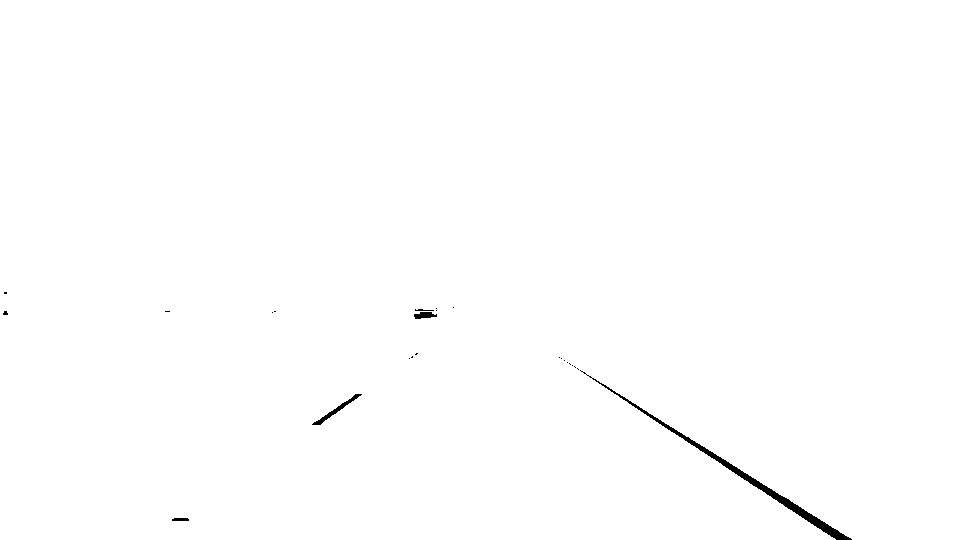

In [44]:
def grid_detection(image_grayscale):
  _, binary = cv2.threshold(image_grayscale, 225, 255, cv2.THRESH_BINARY_INV)
  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (70, 1))
  horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
  vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 60))
  vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, vertical_kernel, iterations=1)
  grid = cv2.add(horizontal_lines, vertical_lines)
  cv2_imshow(grid)
  (alpha,beta)=grid.shape
  return grid

lane_image = cv2.imread('/content/good_lane_image1.jpeg')
gray_image = cv2.cvtColor(lane_image, cv2.COLOR_BGR2GRAY)
grid = grid_detection(gray_image)

540 960


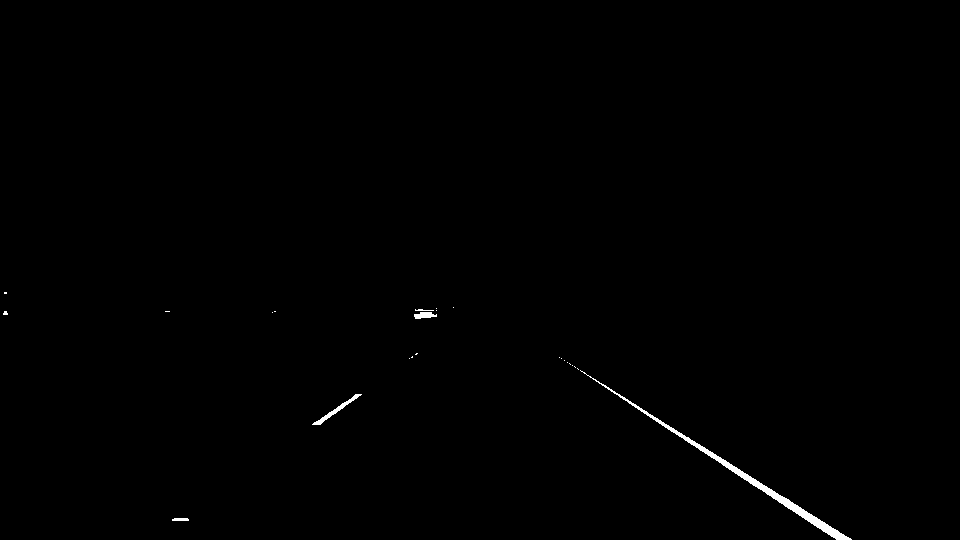

In [45]:
inverted_grid = 255 - grid
alpha,beta = inverted_grid.shape
print(alpha,beta)
inverted_grid[:alpha//2,:]=0
cv2_imshow(inverted_grid)

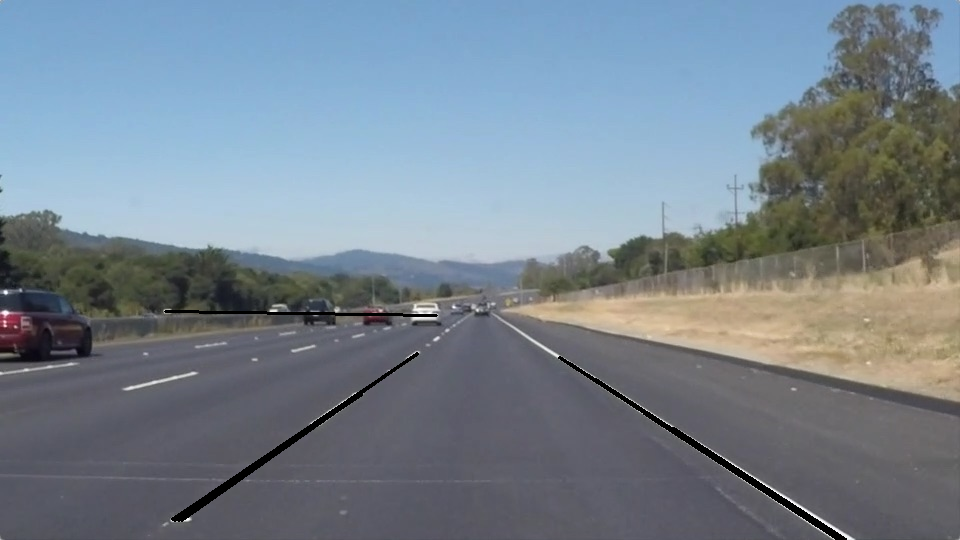

In [46]:
#Hough Transform will give us the lines forming the lanes
def Hough_Transform(masked_edges):
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=400)
    # print(lines)
    return lines

lines = Hough_Transform(inverted_grid)
# Draw the detected lane lines on the lane_image`
max_dist= 0
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # cv2.line(lane_image, (x1, y1), (x2, y2), (0, 0, 0), 2)
        dist = ((x1-x2)**2 + (y1-y2)**2)**(0.5)
        max_dist = max(dist,max_dist)

filtered_lines = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        dist = ((x1-x2)**2 + (y1-y2)**2)**(0.5)
        if(dist>=0.6*max_dist):
           filtered_lines.append([[x1, y1, x2, y2]])
           cv2.line(lane_image, (x1, y1), (x2, y2), (0, 0, 0), 2)


cv2_imshow(lane_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [47]:
if filtered_lines is not None:
    left_lane_points = []
    right_lane_points = []
    left_lane_slope=0
    right_lane_slope=0
    for line in filtered_lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1)
        if slope < -0.3:  # Left lane
            left_lane_slope= left_lane_slope+slope
            left_lane_points.extend([(x1, y1), (x2, y2)])
        elif slope > 0.3:  # Right lane
            right_lane_slope=right_lane_slope+slope
            right_lane_points.extend([(x1, y1), (x2, y2)])

In [48]:
left_lane_points = sorted(left_lane_points, key=lambda point: point[1])
#Reverse sorting by y-cordinate(descending as for the right lane the x,y both increase when you go down the lane)
right_lane_points = sorted(right_lane_points, key=lambda point: point[1], reverse=True)

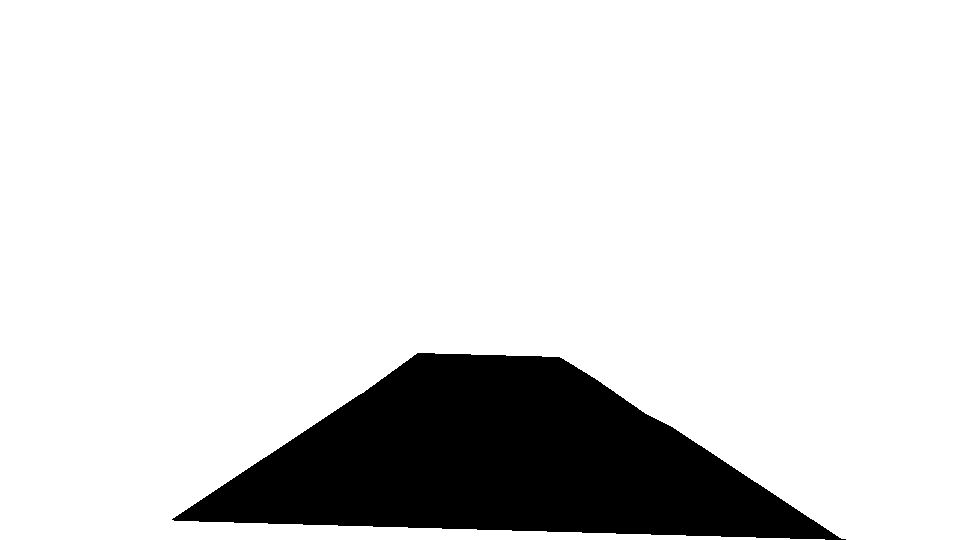

In [49]:
lane_polygon = np.array([left_lane_points + right_lane_points], np.int32)
binary_image = np.ones_like(gray_image) * 255
cv2.fillPoly(binary_image, lane_polygon, 0)

cv2_imshow(binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

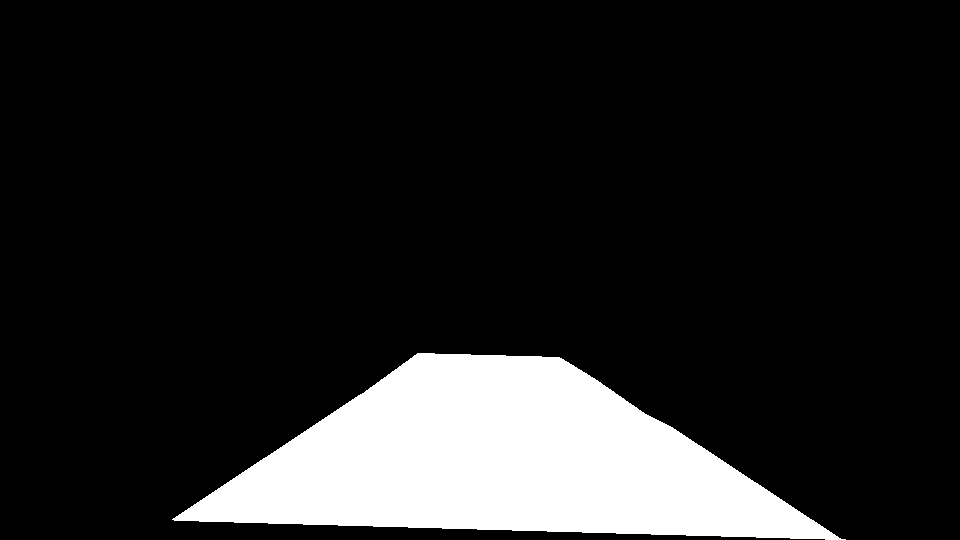

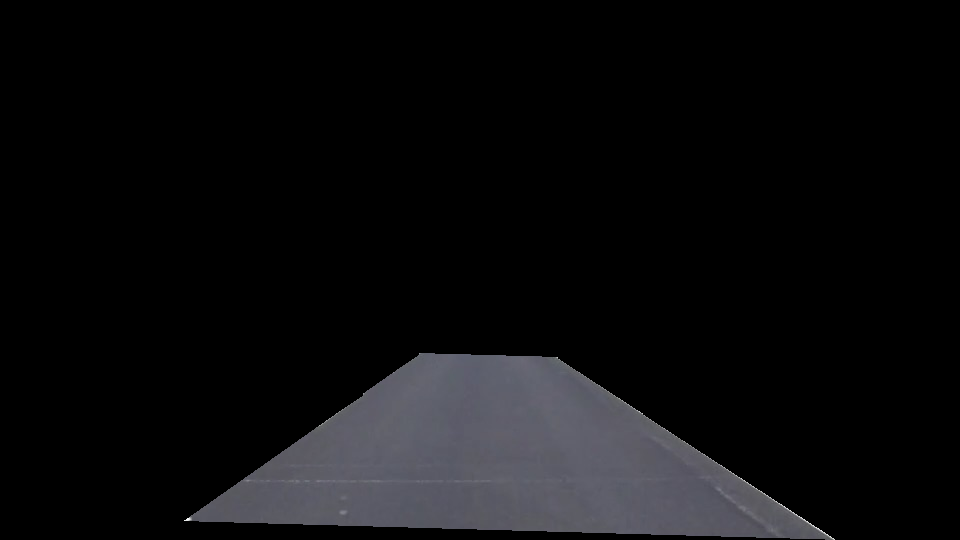

In [50]:
lane_mask = np.zeros_like(gray_image)
cv2.fillPoly(lane_mask, [lane_polygon], 255)  # White area for lanes, black for background

#Convert lane mask to 3-channel image
lane_mask_colored = cv2.cvtColor(lane_mask, cv2.COLOR_GRAY2BGR)
cv2_imshow(lane_mask_colored)

#Apply the lane_mask from above to the original image (subtracting the background)
lane_only_image = cv2.bitwise_and(lane_image, lane_mask_colored)
cv2_imshow(lane_only_image)